In [1]:
import pandas as pd

In [2]:
datapath = r"C:\Users\drang\Downloads\toxic\data\bbc-text.csv\bbc-text.csv"
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<AxesSubplot:xlabel='category'>

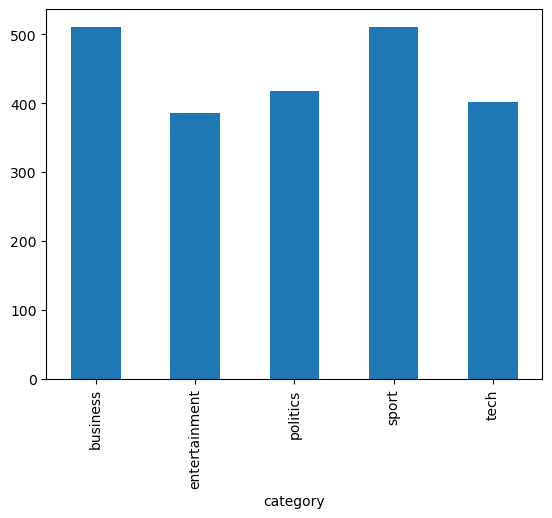

In [3]:
df.groupby("category").size().plot.bar()

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch love today tonight'
bert_input = tokenizer(example_text, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

#pt for pytorch, 10 for max visual
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[ 101,  146, 1209, 2824, 1567, 2052, 3568,  102,    0,    0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [5]:
list(bert_input)

['input_ids', 'token_type_ids', 'attention_mask']

In [6]:
egtxt = tokenizer.decode(bert_input.input_ids[0])
egtxt

'[CLS] I will watch love today tonight [SEP] [PAD] [PAD]'

In [7]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [8]:
import numpy as np
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])
# For example, [2, 3] would, for axis=0, result in ary[:2]'ary[2:3],ary[3:]
print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [9]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [11]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████| 890/890 [03:15<00:00,  4.54it/s]


Epochs: 1 | Train Loss:  0.772                 | Train Accuracy:  0.313                 | Val Loss:  0.655                 | Val Accuracy:  0.559


100%|████████████████████████████████████████████████████████████████████████████████| 890/890 [03:15<00:00,  4.56it/s]


Epochs: 2 | Train Loss:  0.424                 | Train Accuracy:  0.807                 | Val Loss:  0.232                 | Val Accuracy:  0.977


100%|████████████████████████████████████████████████████████████████████████████████| 890/890 [03:15<00:00,  4.54it/s]


Epochs: 3 | Train Loss:  0.160                 | Train Accuracy:  0.978                 | Val Loss:  0.104                 | Val Accuracy:  0.982


100%|████████████████████████████████████████████████████████████████████████████████| 890/890 [03:15<00:00,  4.56it/s]


Epochs: 4 | Train Loss:  0.079                 | Train Accuracy:  0.989                 | Val Loss:  0.066                 | Val Accuracy:  0.995


100%|████████████████████████████████████████████████████████████████████████████████| 890/890 [03:15<00:00,  4.56it/s]


Epochs: 5 | Train Loss:  0.046                 | Train Accuracy:  0.993                 | Val Loss:  0.038                 | Val Accuracy:  0.995


In [12]:
torch.save(model.state_dict(), "BBC CLASSIFY USING BERT1.pt")

In [13]:
model = BertClassifier()
model.load_state_dict(torch.load("BBC CLASSIFY USING BERT1.pt"))
model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [33]:
train, val = Dataset(df_train), Dataset(df_val)

In [64]:
train.__getitem__(2)[1]

array(1)

In [58]:
class A:
    def __init__(self, item):
        self.item = item
    def __getitem__(self, index):
        return self.item[index]
a = A([1, 2, 3])
print(f"First item: {a[0]}")
print(f"Second item: {a[1]}")
print(f"Third item: {a[2]}")

First item: 1
Second item: 2
Third item: 3


In [65]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.996


In [46]:
ss = df_test["text"][8]

In [47]:
texty = [tokenizer(ss, padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")]

In [49]:
texty[0]['input_ids']

tensor([[  101,   192,  2723,  9615,  1320,  4218,  1106,  1339,  5048,  1394,
         16854,  4035,  1403,  1931,  3495,   179,  1320,  3382,   192,  2723,
          9615,  1320,  1209,  1294,  1117,  1263,   118, 21520,  1862,  1121,
          3773,  1222,  5048,  1394, 16854,  1113,  2068,  2149,  6194,   119,
           192,  2723,  9615,  1320,  1150,  1144,  1136,  1307,  1290, 25359,
          1117, 16516,  2093,  1643,  1113,  1542,   184,  5822, 21367,  1197,
          1261,  1226,  1107,  1554,   118,  3232,  2013,  1114,  1207, 26487,
           175,  1348,  7235,  1116,  1113, 26055,  3965,  6194,   119,  1105,
          1103,  1512,   118,  1214,   118,  1385,  4689,   118,  1544,  1209,
          1838,  2068,  2149,  6194,   188,  1119,  2042,  6378,  4355,  1801,
          1120,   182,  2149,  6447,  2427,  1113,  1103,  6757,   119,  1133,
          1207, 26487,  1900,  1104,  4896,   187, 12809,  1105, 11899,  1163,
           131,  1119,   188,  2503,  1105,  1195,  

In [50]:
mo = model(texty[0]["input_ids"], texty[0]["attention_mask"])

In [71]:
print(mo.argmax(dim=1))
list(labels.keys())[mo.argmax(dim=1).item()] #access dict key using values

tensor([2])


'sport'

In [70]:
list(labels.keys())[2]

'sport'